In [1]:
!pip install gym_sokoban

In [2]:
import argparse
import gym
import gym
import gym_sokoban
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import torchvision

from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import math
import random 
import pandas as pd 
import seaborn as sns

In [3]:
image_transformations = T.Compose([
                    T.ToPILImage(),
                    T.Resize(64, interpolation= InterpolationMode.BILINEAR),
                    T.ToTensor(),
                    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])





In [4]:
MAX_NUM_OF_ITERATIONS = 150
seed = 999

In [5]:
env = gym.make('PushAndPull-Sokoban-v2')

env.max_steps =  MAX_NUM_OF_ITERATIONS
screen = env.render(mode='rgb_array')
env.seed(seed)
torch.manual_seed(seed)
num_of_actions = env.action_space.n
num_of_actions

13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


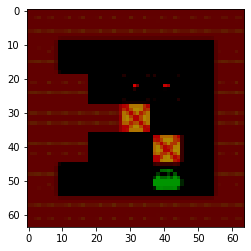

In [6]:
state_transformed = image_transformations(env.reset())
plt.imshow(state_transformed.permute(1,2,0).detach().cpu().numpy())

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
ActionLog = namedtuple('ActionLog', ['log_prob'])

In [17]:
class Net(nn.Module):
    def __init__(self, num_of_actions):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.pre_actions1 = nn.Linear(400, 200)
        self.pre_actions2 = nn.Linear(200, 100)
        self.actions = nn.Linear(100, num_of_actions)

    def forward(self, x):

        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = torch.flatten(x, 1) 

        actions = F.leaky_relu(self.pre_actions1(x))
        actions = F.leaky_relu(self.pre_actions2(actions))
        actions = F.leaky_relu(self.actions(actions))
        actions = F.softmax(actions, dim=1)

        return actions

    def init_weights(self):

      torch.nn.init.xavier_uniform_(self.conv1.weight)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      torch.nn.init.xavier_uniform_(self.pre_actions1.weight)
      torch.nn.init.xavier_uniform_(self.pre_actions2.weight)

      torch.nn.init.xavier_uniform_(self.actions.weight)

  

      return self

class Agent:
    def __init__(self, net):
        self.net = net 

        self.saved_actions = []
        self.rewards = []

    def run_on_state(self, state):

        state = state.to(device)
        actions_prob = self.net(state)
      
        return  actions_prob


In [53]:
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.2
EPS_DECAY = 6000
steps_done = 0

In [56]:
def select_action(state):
  
    global steps_done
    steps_done += 1

    state = image_transformations(state).unsqueeze(0)
    probs = model.run_on_state(state)
    categorical = Categorical(probs)

    action = categorical.sample()
    model.saved_actions.append(ActionLog(categorical.log_prob(action)))


    return action.item()

In [75]:
def train_on_episode():

    saved_actions = model.saved_actions
    policy_losses = [] 
    returns = []

    step_total_r = 0
    for step_immediate_rewars in reversed(model.rewards):
        step_total_r = step_immediate_rewars + GAMMA * step_total_r
        returns.insert(0, step_total_r)

    returns = torch.tensor(returns).to(device)

    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (saved_action, step_total_r) in zip(saved_actions, returns):
        policy_losses.append(-saved_action.log_prob * step_total_r)


    optimizer.zero_grad()
  
    loss = torch.cat(policy_losses).sum()

    loss.backward()
    optimizer.step()
    
    model.rewards = []
    model.saved_actions = []

    return loss

In [76]:
net = Net(num_of_actions).init_weights().to(device)

model = Agent(net)

optimizer = optim.RMSprop(net.parameters(), lr=0.001)

eps = np.finfo(np.float32).eps.item()

In [ ]:
episodes_durations = []
steps_done = 0
net.train()

for episode_number in count(1):

  if episode_number % 50 == 0:
    print('episode_number {}'.format(episode_number))

  state = env.reset()

  for step_number in range(1, 10000):

    action = select_action(state)
    
    state, reward, done, _ = env.step(action)
            
    model.rewards.append(reward)

    if done:
      episodes_durations.append(step_number)
      break
  
  train_on_episode()



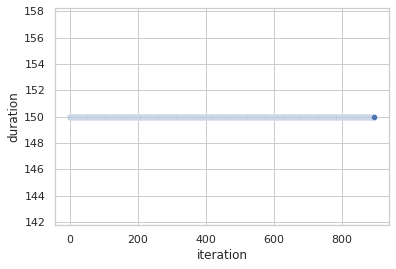

In [63]:


durations_df = pd.DataFrame([(iteration, duration) for (iteration, duration) in enumerate(episodes_durations)], columns =["iteration", "duration"])
sns.set_theme(style="whitegrid")

sns.scatterplot(data=durations_df, x="iteration", y="duration")

In [66]:
net.eval()

state1 = image_transformations(state).unsqueeze(0).to(device)

net(state1)

tensor([[1.7731e-13, 3.5692e-16, 7.0426e-14, 3.4910e-16, 3.2052e-16, 1.0000e+00,
         3.2384e-16, 3.2431e-16, 3.5731e-16, 3.1402e-16, 3.5794e-16, 3.6557e-10,
         3.5925e-16]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [67]:
eps

1.1920928955078125e-07